
# Exploratory Data Analysis and Clustering

This notebook explores the **claims insurance dataset** using Exploratory Data Analysis (EDA), Principal Component Analysis (PCA), and K-Means clustering.  
We will visualize the data in **3 dimensions (PCA = 3)**, and finally compare the clustering results **with and without one-hot encoding** of categorical variables.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D


In [2]:

# Load training data
data = pd.read_csv('data/claims_train.csv')


# Preview data
data.head()


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,2122523.0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
1,3173420.0,0,0.10,D,7,17,80,95,B2,Regular,598,R25
2,1188619.0,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
3,31400.0,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
4,3138755.0,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53


In [3]:

# Basic overview of dataset
data.info()
data.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542410 entries, 0 to 542409
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       542410 non-null  float64
 1   ClaimNb     542410 non-null  int64  
 2   Exposure    542410 non-null  float64
 3   Area        542410 non-null  object 
 4   VehPower    542410 non-null  int64  
 5   VehAge      542410 non-null  int64  
 6   DrivAge     542410 non-null  int64  
 7   BonusMalus  542410 non-null  int64  
 8   VehBrand    542410 non-null  object 
 9   VehGas      542410 non-null  object 
 10  Density     542410 non-null  int64  
 11  Region      542410 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 49.7+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IDpol,542410.0,NaN,NaN,NaN,2623260.276604,1641808.916372,1.0,1158401.25,2272433.5,4046605.5,6114330.0
ClaimNb,542410.0,NaN,NaN,NaN,0.053122,0.238785,0.0,0.0,0.0,0.0,11.0
Exposure,542410.0,NaN,NaN,NaN,0.52884,0.364463,0.002732,0.18,0.49,0.99,2.01
Area,542410,6,C,153287,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehPower,542410.0,NaN,NaN,NaN,6.453281,2.050506,4.0,5.0,6.0,7.0,15.0
VehAge,542410.0,NaN,NaN,NaN,7.045768,5.660827,0.0,2.0,6.0,11.0,100.0
DrivAge,542410.0,NaN,NaN,NaN,45.503164,14.135435,18.0,34.0,44.0,55.0,100.0
BonusMalus,542410.0,NaN,NaN,NaN,59.761546,15.639321,50.0,50.0,50.0,64.0,230.0
VehBrand,542410,11,B12,132831,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehGas,542410,2,Regular,276723,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

# Handle missing values if any (none expected but check)
data = data.dropna()

# Remove extreme or invalid exposures (>1)
data = data[data['Exposure'] <= 1]

# Reset index after filtering
data.reset_index(drop=True, inplace=True)

print(f"Remaining rows after cleaning: {len(data)}")


Remaining rows after cleaning: 541416


In [5]:

# Select numeric features for PCA
numeric_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numeric_features])

# Apply PCA with 3 components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

print('Explained variance ratio:', np.round(pca.explained_variance_ratio_, 3))


Explained variance ratio: [0.302 0.22 ]


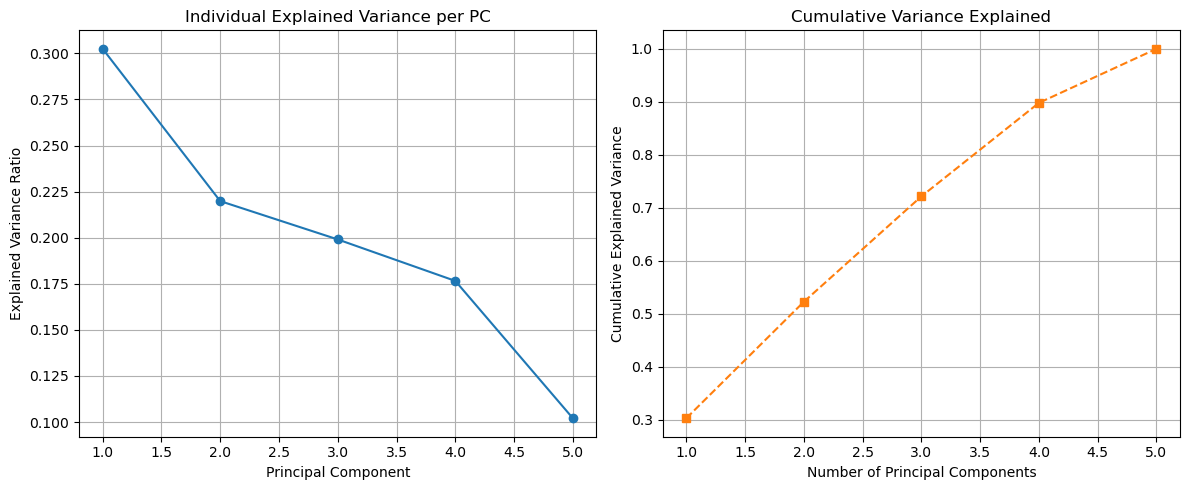

PC1: 0.302 variance, 0.302 cumulative
PC2: 0.220 variance, 0.522 cumulative
PC3: 0.199 variance, 0.721 cumulative
PC4: 0.177 variance, 0.898 cumulative
PC5: 0.102 variance, 1.000 cumulative


In [6]:
# --- PCA variance trade-off: two line plots (individual + cumulative) ---

pca_full = PCA().fit(scaled_data)
explained = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained)
pcs = np.arange(1, len(explained) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Individual explained variance
axes[0].plot(pcs, explained, marker='o', color='tab:blue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Individual Explained Variance per PC')
axes[0].grid(True)

# Cumulative explained variance
axes[1].plot(pcs, cumulative, marker='s', linestyle='--', color='tab:orange')
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print numeric summary
for i, (var, cum) in enumerate(zip(explained, cumulative)):
    print(f"PC{i+1}: {var:.3f} variance, {cum:.3f} cumulative")


chosen 3 components

k=2: silhouette=0.449
k=3: silhouette=0.471
k=4: silhouette=0.350
k=5: silhouette=0.352
k=6: silhouette=0.320
k=7: silhouette=0.320
k=8: silhouette=0.337
k=9: silhouette=0.329


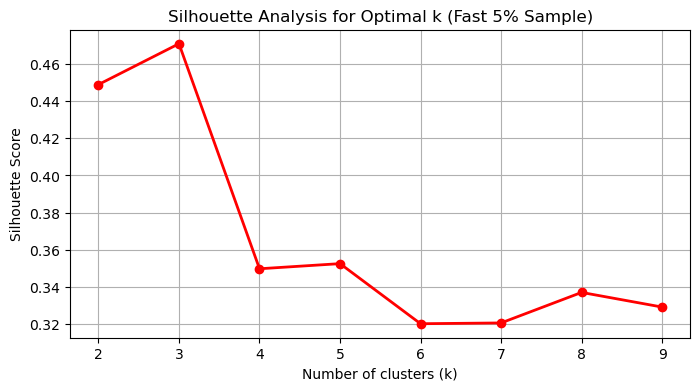

👉 Best k by silhouette score (subset): 3


In [7]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# --- Use only a 5% random sample for KMeans speed ---
rng = np.random.default_rng(seed=42)
sample_frac = 0.2
pca_sample = pca_data[
    rng.choice(range(len(pca_data)), size=int(len(pca_data) * sample_frac), replace=False)
]

# --- Use smaller subsample (e.g., 2000 points) for silhouette scoring ---
silhouette_subsample = rng.choice(
    len(pca_sample), size=min(2000, len(pca_sample)), replace=False
)

silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(pca_sample)

    # Compute silhouette on small subset for speed
    sil = silhouette_score(
        pca_sample[silhouette_subsample],
        labels[silhouette_subsample]
    )
    silhouette_scores.append(sil)
    print(f"k={k}: silhouette={sil:.3f}")

# --- Plot silhouette scores ---
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, 'ro-', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k (Fast 5% Sample)')
plt.grid(True)
plt.show()

# --- Print best k ---
best_k = K[np.argmax(silhouette_scores)]
print(f"👉 Best k by silhouette score (subset): {best_k}")


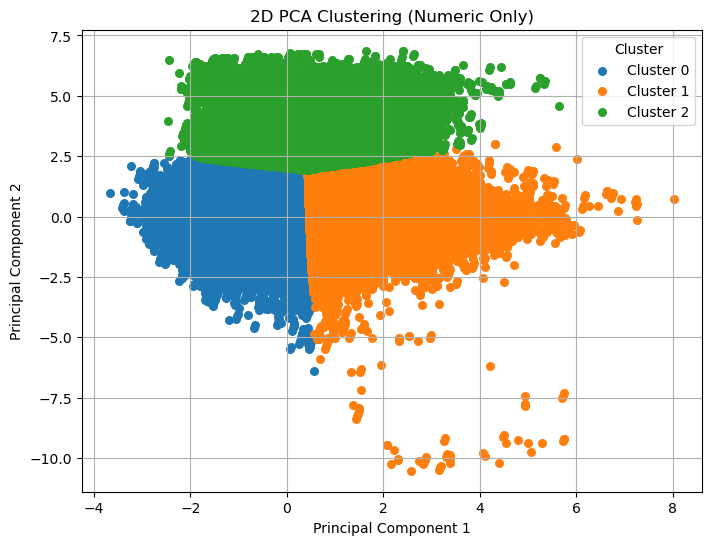

In [8]:
# Run K-Means clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
data['Cluster'] = kmeans.fit_predict(pca_data)

# 2D PCA visualization (PC1 vs PC2)
plt.figure(figsize=(8,6))

# Loop through each cluster and plot separately so we can label them
for cluster_id in sorted(data['Cluster'].unique()):
    cluster_points = pca_data[data['Cluster'] == cluster_id]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        s=30,
        label=f'Cluster {cluster_id}'
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Clustering (Numeric Only)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


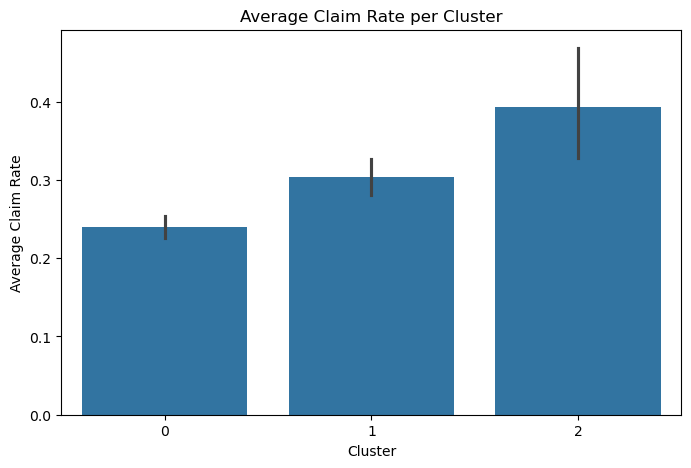

In [9]:
# Beregn claim rate
data['ClaimRate'] = data['ClaimNb'] / data['Exposure']

plt.figure(figsize=(8,5))
sns.barplot(x='Cluster', y='ClaimRate', data=data, estimator=np.mean)
plt.title('Average Claim Rate per Cluster')
plt.ylabel('Average Claim Rate')
plt.show()


In [10]:
# --- Gennemsnit for numeriske variabler pr. cluster (uden OHE) ---
cluster_means = data.groupby('Cluster')[numeric_features + ["ClaimNb", "Exposure"]].mean().round(3)
print(cluster_means)


         VehPower  VehAge  DrivAge  BonusMalus    Density  ClaimNb  Exposure
Cluster                                                                     
0           6.577   6.627   51.075      51.807   1124.616    0.051     0.569
1           6.048   8.381   31.821      78.922   1565.606    0.058     0.435
2           7.512   3.685   46.064      63.089  21549.032    0.067     0.445



Top features influencing PC1:
BonusMalus    0.694880
DrivAge       0.679794
VehAge        0.176932
VehPower      0.137512
Density       0.069340
Name: PC1, dtype: float64

Top features influencing PC2:
Density       0.744569
VehAge        0.596679
VehPower      0.281432
BonusMalus    0.093391
DrivAge       0.040818
Name: PC2, dtype: float64


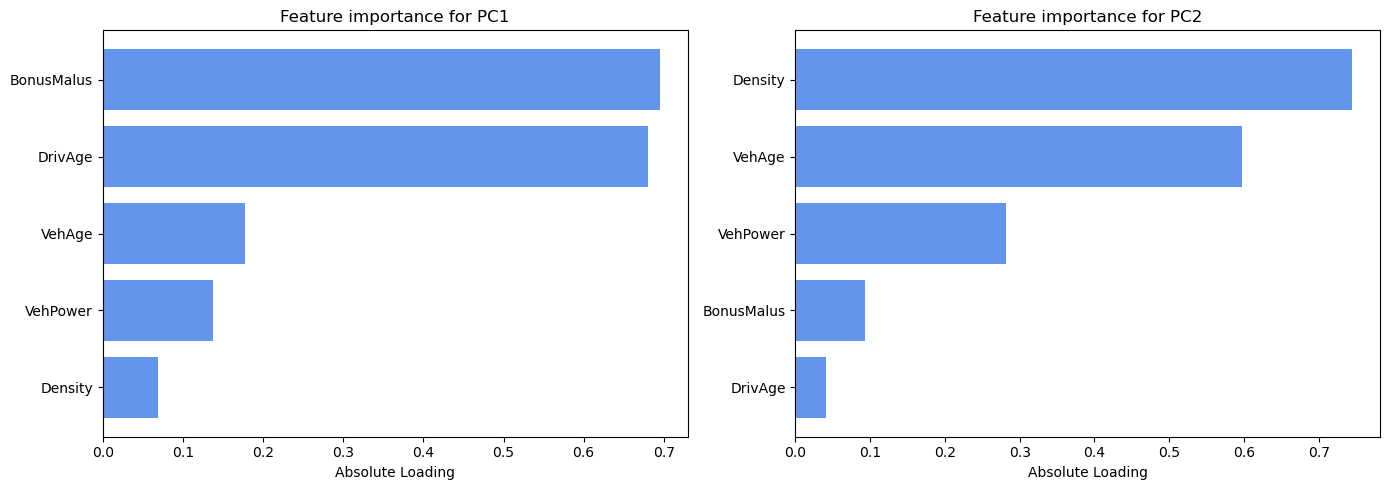


Explained variance by components: [30.25 21.99]%
Total variance explained by 2 PCs: 52.23%


In [42]:
# --- Select only numeric features (no dummy variables, no targets) ---
numeric_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
data_pca_ready_num = data[numeric_features].copy()

# --- Fit PCA (2 components) ---
scaler = StandardScaler()
scaled_data_num = scaler.fit_transform(data_pca_ready_num)
pca_num = PCA(n_components=2)
pca_data_num = pca_num.fit_transform(scaled_data_num)

# --- Feature importance (loadings) ---
feature_names_num = data_pca_ready_num.columns
loadings_num = pd.DataFrame(
    pca_num.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_num.n_components_)],
    index=feature_names_num
)

# --- Print top features per PC ---
for i in range(2):
    print(f"\nTop features influencing PC{i+1}:")
    print(loadings_num.iloc[:, i].abs().sort_values(ascending=False).head(10))

# --- Visualize loadings (bar plots) ---
num_features = len(feature_names_num)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, ax in enumerate(axes):
    top_features = loadings_num.iloc[:, i].abs().sort_values(ascending=False)
    ax.barh(top_features.index[::-1], top_features.values[::-1], color='cornflowerblue')
    ax.set_title(f'Feature importance for PC{i+1}')
    ax.set_xlabel('Absolute Loading')
plt.tight_layout()
plt.show()

# --- Explained variance ratio ---
explained_var = np.round(pca_num.explained_variance_ratio_ * 100, 2)
total_var = np.round(np.sum(pca_num.explained_variance_ratio_) * 100, 2)
print(f"\nExplained variance by components: {explained_var}%")
print(f"Total variance explained by 2 PCs: {total_var}%")


NEEEEEW ONE FOR ENCODED variables

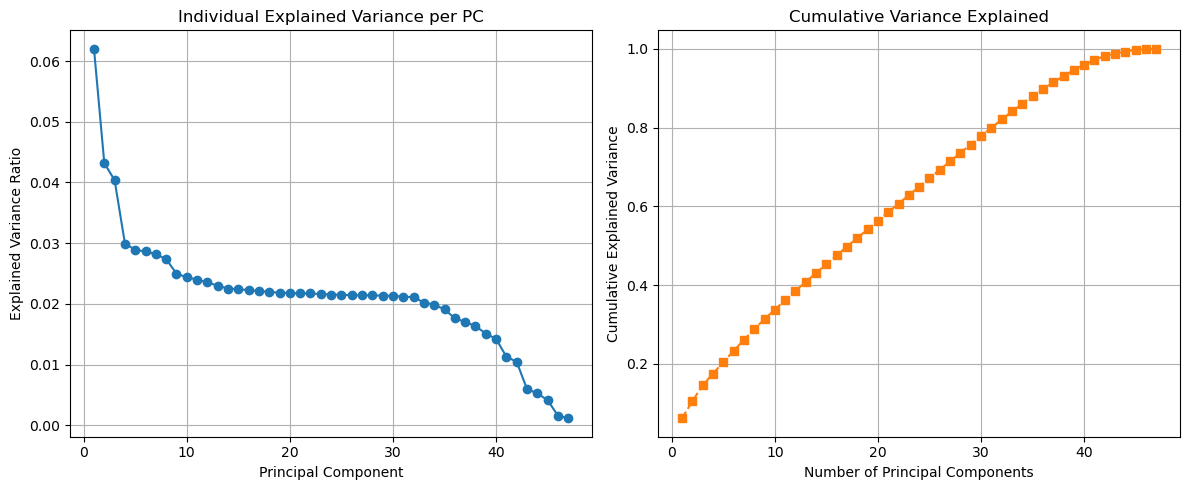

In [23]:
# --- One-hot encode categorical variables (dummy variables) ---
categorical_features = ['VehBrand', 'VehGas', 'Area', 'Region']
numeric_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# --- Scale all features ---
scaler = StandardScaler()
scaled_data_encoded = scaler.fit_transform(data_encoded[numeric_features + [col for col in data_encoded.columns if col not in numeric_features and col != 'Cluster']])


# --- Reduce to chosen number of components ---
pca = PCA(n_components=4)
pca_data_encoded = pca.fit_transform(scaled_data_encoded)

# --- STEP 1: Fit PCA with all components ---
pca_full = PCA().fit(scaled_data_encoded)

explained = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained)
pcs = np.arange(1, len(explained) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Individual variance line plot
axes[0].plot(pcs, explained, marker='o', color='tab:blue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Individual Explained Variance per PC')
axes[0].grid(True)

# Cumulative variance line plot
axes[1].plot(pcs, cumulative, marker='s', linestyle='--', color='tab:orange')
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].grid(True)

plt.tight_layout()
plt.show()

4 comoponents is good elbow theory but we choose 3 for intepretablity

k=2: silhouette=0.302
k=3: silhouette=0.339
k=4: silhouette=0.391
k=5: silhouette=0.347
k=6: silhouette=0.312
k=7: silhouette=0.299
k=8: silhouette=0.301
k=9: silhouette=0.261


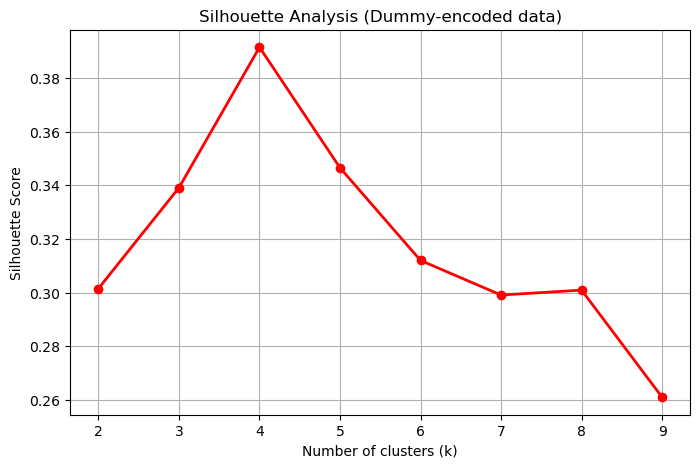

👉 Best k by silhouette score: 4


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# --- Stable random sampling for reproducibility ---
rng = np.random.default_rng(seed=42)

K = range(2, 10)
silhouette_scores = []

# Sample 20 % of points for speed
pca_sample = pca_data_encoded[
    rng.choice(len(pca_data_encoded), size=int(len(pca_data_encoded) * 0.2), replace=False)
]
# Use smaller subset (e.g. 2000) for silhouette computation
silhouette_sample = rng.choice(len(pca_sample), size=min(2000, len(pca_sample)), replace=False)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(pca_sample)
    sil = silhouette_score(pca_sample[silhouette_sample], labels[silhouette_sample])
    silhouette_scores.append(sil)
    print(f"k={k}: silhouette={sil:.3f}")

plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'ro-', linewidth=2)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis (Dummy-encoded data)")
plt.grid(True)
plt.show()

best_k = K[np.argmax(silhouette_scores)]
print(f"👉 Best k by silhouette score: {best_k}")


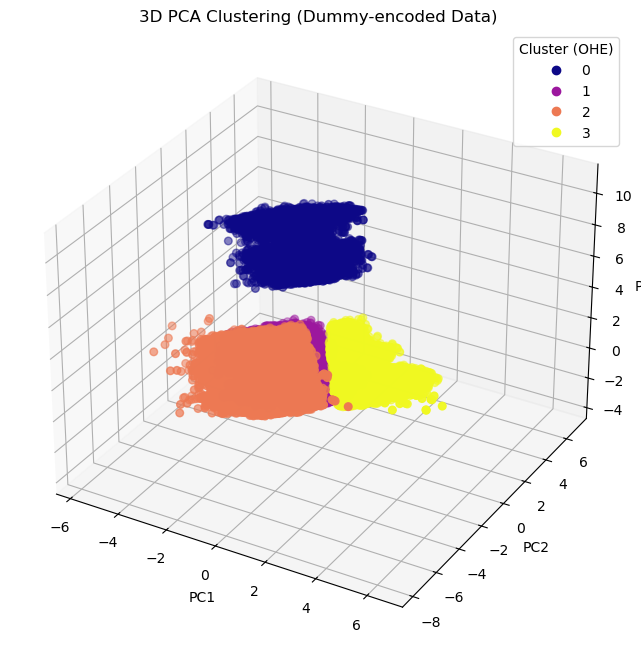

In [25]:
# --- Final clustering using best_k ---
kmeans_encoded = KMeans(n_clusters=best_k, n_init=10, random_state=42)
data['Cluster_OHE'] = kmeans_encoded.fit_predict(pca_data_encoded)

# --- 3D visualization of PCA clusters ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_data_encoded[:, 0],
    pca_data_encoded[:, 1],
    pca_data_encoded[:, 2],
    c=data['Cluster_OHE'],
    cmap='plasma',
    s=30
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Clustering (Dummy-encoded Data)')
plt.legend(*scatter.legend_elements(), title='Cluster (OHE)')
plt.show()


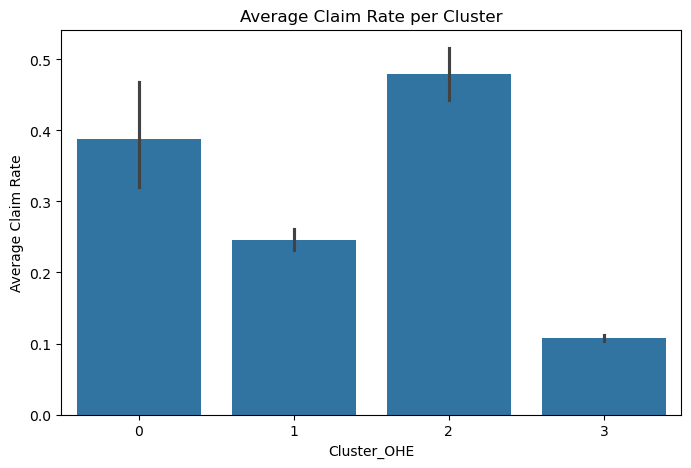

In [26]:
# Beregn claim rate
data['ClaimRate'] = data['ClaimNb'] / data['Exposure']

plt.figure(figsize=(8,5))
sns.barplot(x='Cluster_OHE', y='ClaimRate', data=data, estimator=np.mean)
plt.title('Average Claim Rate per Cluster')
plt.ylabel('Average Claim Rate')
plt.show()

In [36]:
cluster_means_ohe = data.groupby('Cluster_OHE')[["ClaimRate", "ClaimNb", "Exposure"]+numeric_features].mean().round(3)
print(cluster_means_ohe)

             ClaimRate  ClaimNb  Exposure  VehPower  VehAge  DrivAge  \
Cluster_OHE                                                            
0                0.388    0.065     0.453     7.022   4.607   46.582   
1                0.246    0.035     0.364     6.922   2.565   48.837   
2                0.479    0.063     0.393     6.124   8.442   35.299   
3                0.108    0.056     0.724     6.376   8.826   50.741   

             BonusMalus    Density  
Cluster_OHE                         
0                63.470  22030.469  
1                55.964   1445.188  
2                72.567   2076.167  
3                52.655    532.866  



Top 10 features influencing PC1:
Density         0.437356
VehBrand_B12    0.431903
Area_F          0.345358
Region_R24      0.315634
VehAge          0.307996
IDpol           0.292595
Area_E          0.248403
VehBrand_B2     0.231373
Area_C          0.165301
Area_B          0.121161
Name: PC1, dtype: float64

Top 10 features influencing PC2:
Density         0.442607
Area_F          0.364533
VehBrand_B12    0.353628
VehAge          0.287456
BonusMalus      0.276724
IDpol           0.267672
DrivAge         0.235553
Area_E          0.225067
Area_C          0.218527
Region_R91      0.147025
Name: PC2, dtype: float64

Top 10 features influencing PC3:
DrivAge        0.482525
BonusMalus     0.467380
Area_F         0.343872
Area_D         0.294855
Region_R24     0.237730
Density        0.233258
Region_R31     0.216578
VehBrand_B3    0.151019
VehPower       0.148549
VehBrand_B2    0.146539
Name: PC3, dtype: float64


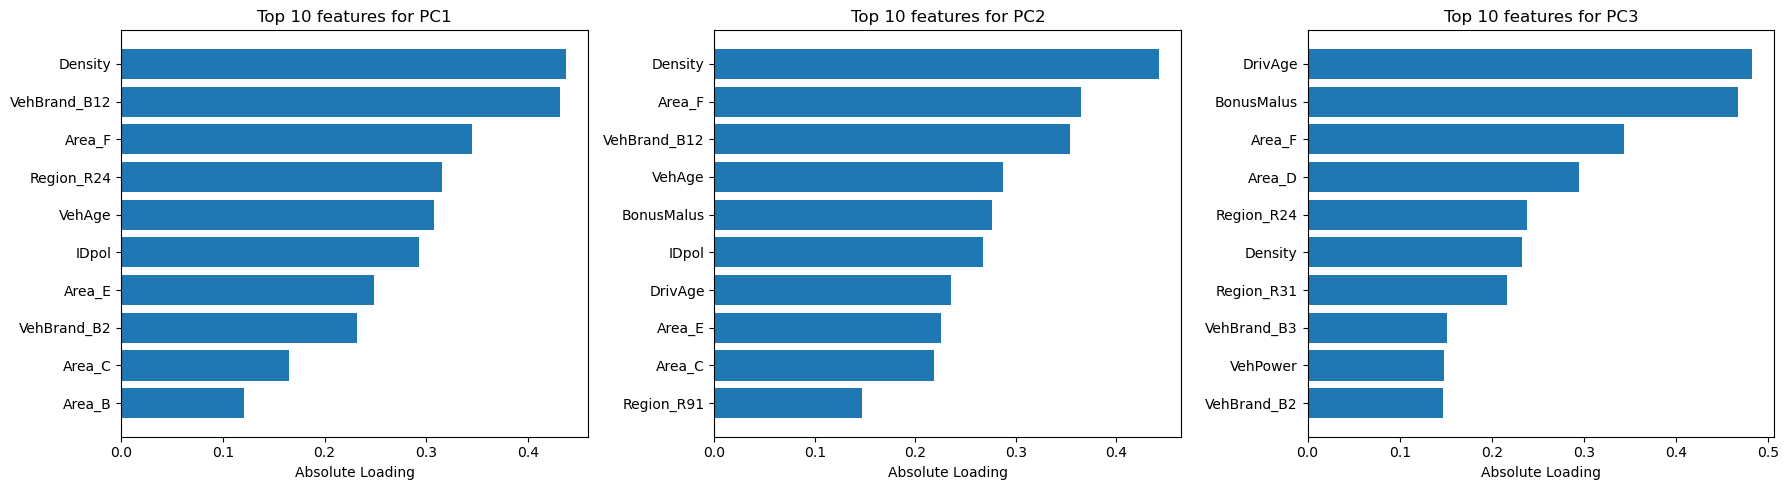

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Prepare clean dataset for PCA ---
columns_to_exclude = ['ClaimNb', 'Exposure', 'ClaimRate', 'Cluster', 'Cluster_OHE', 'IDPol']
data_pca_ready = data_encoded.drop(columns=columns_to_exclude, errors='ignore')

# --- Fit PCA ---
scaler = StandardScaler()
scaled_data_encoded = scaler.fit_transform(data_pca_ready)
pca = PCA(n_components=3)
pca_data_encoded = pca.fit_transform(scaled_data_encoded)

# --- Feature importance (loadings) ---
feature_names = data_pca_ready.columns
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=feature_names
)

# --- Print top 10 features per PC ---
for i in range(3):
    print(f"\nTop 10 features influencing PC{i+1}:")
    print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(10))

# --- Visualize loadings ---
num_features = 10
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axes):
    top_features = loadings.iloc[:, i].abs().sort_values(ascending=False).head(num_features)
    ax.barh(top_features.index[::-1], top_features.values[::-1])
    ax.set_title(f'Top {num_features} features for PC{i+1}')
    ax.set_xlabel('Absolute Loading')
plt.tight_layout()
plt.show()

